Inteligencia Computacional EL4106-1

Facultad de Ciencias Físicas y Matemáticas

Universidad de Chile





# Proyecto
### Redes neuronales convolucionales




Alumna: Isabel Marx

Profesor: Javier Ruiz del Solar 

Auxiliar: Patricio Loncomilla

Fecha de entrega: 12 de Julio de 2022

# 1. Introducción

El proyecto final del curso Inteligencia Computacional se realiza utilizando redes neuronales convolucionales. Se requiere clasificar una base de datos de señales mioeléctricas, tomadas por 8 electrodos en distintas posiciones del antebrazo humano, con el objetivo de clasificar y asignar movimientos musculares a distintos gestos de mano. Una aplicación de este trabajo es la implementación de brazos robóticos para personas que no poseen manos, ya sea por desordenes genéticos o amputaciones.

Se cuenta con las muestras de 36 sujetos, cada cual realizó dos monitoreos diferentes, que a su vez contienen una cantidad de ocho gestos repetidos dos veces. Se requiere clasificar las señales en seis de estos ocho gestos. Cada gesto se realiza por un tiempo de 1.5 a 2 segundos, intercalados por la posición en descanso de la mano. Para 30 sujetos se cuenta con las etiqutas de gestos respectivas, mientras que se deben clasificar las señales de los 6 sujetos restantes, con tal de obtener un resultado en una competencia Kaggle realizada entre las y los integrates de este curso.

En las secciones de este informe se presenta el código implementado, junto con descripciones que permiten entender los pasos seguidos. En la sección de Lectura de datos se importan los archivos y se generan conjuntos accesibles. Luego, en la sección de Gráficos, se presentan los gráficos de las señales obtenidas y en la sección de Imágenes, las imágenes gráficas de las muestras generadas. Posteriormente, en la sección de Estructura de red, se presenta la arquitectura utilizada. Luego, en la sección de Resultados se presentan las métricas de evaluación *accuracy* y la matriz de confusión respectiva, junto con los resultados de la competencia en Kaggle. Por último, se tiene la sección de Análisis de resultados y luego, Conclusiones, donde se tratan los errores encontrados en la realización de esta actividad y las proyecciones de mejoras, junto con los aprendizajes obtenidos y otras reflexiones.

## Imports

Se importan las librerías utilizadas, tales como pandas, numpy, pytorch, matplotlib, seaborn, además de aquellas requeridas para la lectura inicial de la base de datos.

## Para cargar datos desde drive, descomentar:

In [1]:

from google.colab import drive
drive.mount('/content/drive')

test_path = '/content/drive/My Drive/ProyectoIC/ventana/windows_test.csv'
train_path = '/content/drive/My Drive/ProyectoIC/train/subj'


Mounted at /content/drive


## Para cargar datos desde local, descomentar:

In [2]:
"""
### Seleccionar 2 archivos:
### Dataset_de_senales_para_entrenamiento.zip y Dataset_de_ventanas_de_prueba.zip

from google.colab import files
uploaded = files.upload()

!unzip Dataset_de_senales_para_entrenamiento.zip
!unzip Dataset_de_ventanas_de_prueba.zip

test_path = '/content/emg_dataset/windows_test.csv'
train_path = '/content/emg_dataset/train/subj'
"""

"\n### Seleccionar 2 archivos:\n### Dataset_de_senales_para_entrenamiento.zip y Dataset_de_ventanas_de_prueba.zip\n\nfrom google.colab import files\nuploaded = files.upload()\n\n!unzip Dataset_de_senales_para_entrenamiento.zip\n!unzip Dataset_de_ventanas_de_prueba.zip\n\ntest_path = '/content/emg_dataset/windows_test.csv'\ntrain_path = '/content/emg_dataset/train/subj'\n"

In [3]:
import io
import os
import gc
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import FuncFormatter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import time

## Lectura de datos

Se cuenta con 61 archivos: uno con las muestras de los 6 sujetos sin etiquetadas a clasificar, y los restantes corresponden a las dos series realizadas por cada uno de los 30 sujetos utilizadas en el aprendizaje del modelo. A continuación se leen los archivos cargados desde una carpeta en Google Drive y se almacenan en conjuntos manipulables. Los 30 sujetos se dividen en 3 conjuntos: 80% entrenamiento, 10% validación y 10% prueba(df_train, df_val, df_prueba). Las ventanas 'windows_test' se denominan conjunto test(df_test), diferenciándose del conjunto prueba.

## Datos de test

In [4]:
# Se importan y leen los datos de prueba:

test = open(test_path,'r')
test = np.genfromtxt(test_path, delimiter="\t",names=True, dtype=None, encoding='utf-8')

windows_test = []
for m in range(672):
  t0 = str(test[m][0]).split(",")
  t1 = t0[1:]
  t1 = [float(s) for s in t1]
  t = []
  i = 0
  while i < 8:
    t_ = t1[i*800:(i+1)*800]
    i += 1
    t.append(t_)

  t = np.array(t)
  windows_test.append(t)
windows_test = np.array(windows_test)

In [5]:
windows_test.shape

(672, 8, 800)

## Datos de entrenaiento, validación y prueba

In [6]:
subjects = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30']
subj_txt = {}
for subj in subjects:
  subj_txt[int(subj)] = {}
  for txt in [1,2]:
    data = open(train_path+subj+'/'+str(txt)+'.txt','r')
    a = data.readline()
    i = 0
    k = 0
    while a[i] != '\n':
      if a[i] == '\t':
        k += 1
      i += 1
    data.seek(0)
    columns = []
    j = 0
    w = ''
    while j < k+1:
      l = data.read(1)
      if l == '\n' or l == '\t':
        columns.append(w)
        w = ''
        j += 1
      else:
        w += l
    dataset = []
    j=0
    l = data.read(1)
    while l != '' and j<11:
      row = []
      for column in columns:
        w = ''
        while l != '\t' and l != '\n':
          w += l
          l = data.read(1)
        row.append(float(w))
        l = data.read(1)
        j = k+1
      dataset.append(row)
    data.close()
    subj_txt[int(subj)][txt] = pd.DataFrame(np.array(dataset), columns=columns)


Se descartan las muestras con etiquetas 0 o 7, obteniéndose conjuntos con muestras para cada realización sucesivas, de la forma [1, 2, ..., 5, 6, 1, 2, ..., 5, 6].

In [7]:
# Se eliminan las etiquetas 0 y 7:

for subj in subjects:
  for txt in [1,2]:
    subj_txt[int(subj)][txt] = subj_txt[int(subj)][txt][subj_txt[int(subj)][txt]['class'] != 0]
    subj_txt[int(subj)][txt] = subj_txt[int(subj)][txt][subj_txt[int(subj)][txt]['class'] != 7]

Se separan cada uno de estos conjuntos en subconjuntos, agrupados cada vez que hay un cambio en la clase en la línea de tiempo, teniéndose 12 subconjuntos por conjunto.

In [8]:
windows = {}

for subj in list(range(1,31)):
  windows[subj] = {}
  for txt in [1,2]:
    windows[subj][txt] = {}

# Clase 1
for subj in list(range(1,31)):
  for txt in [1,2]:
    subj_txt[subj][txt]['group'] = subj_txt[subj][txt]['class'].ne(subj_txt[subj][txt]['class'].shift()).cumsum()
    dfs_by_classes = subj_txt[subj][txt].groupby('group')
    windows[subj][txt][1] = []
    for name, df in dfs_by_classes:
      if df.iloc[0,9] == 1:
        windows[subj][txt][1].append(df)

# Clase 2
for subj in list(range(1,31)):
  for txt in [1,2]:
    subj_txt[subj][txt]['group'] = subj_txt[subj][txt]['class'].ne(subj_txt[subj][txt]['class'].shift()).cumsum()
    dfs_by_classes = subj_txt[subj][txt].groupby('group')
    windows[subj][txt][2] = []
    for name, df in dfs_by_classes:
      if df.iloc[0,9] == 2:
        windows[subj][txt][2].append(df)

# Clase 3
for subj in list(range(1,31)):
  for txt in [1,2]:
    subj_txt[subj][txt]['group'] = subj_txt[subj][txt]['class'].ne(subj_txt[subj][txt]['class'].shift()).cumsum()
    dfs_by_classes = subj_txt[subj][txt].groupby('group')
    windows[subj][txt][3] = []
    for name, df in dfs_by_classes:
      if df.iloc[0,9] == 3:
        windows[subj][txt][3].append(df)

# Clase 4
for subj in list(range(1,31)):
  for txt in [1,2]:
    subj_txt[subj][txt]['group'] = subj_txt[subj][txt]['class'].ne(subj_txt[subj][txt]['class'].shift()).cumsum()
    dfs_by_classes = subj_txt[subj][txt].groupby('group')
    windows[subj][txt][4] = []
    for name, df in dfs_by_classes:
      if df.iloc[0,9] == 4:
        windows[subj][txt][4].append(df)

# Clase 5
for subj in list(range(1,31)):
  for txt in [1,2]:
    subj_txt[subj][txt]['group'] = subj_txt[subj][txt]['class'].ne(subj_txt[subj][txt]['class'].shift()).cumsum()
    dfs_by_classes = subj_txt[subj][txt].groupby('group')
    windows[subj][txt][5] = []
    for name, df in dfs_by_classes:
      if df.iloc[0,9] == 5:
        windows[subj][txt][5].append(df)

# Clase 6
for subj in list(range(1,31)):
  for txt in [1,2]:
    subj_txt[subj][txt]['group'] = subj_txt[subj][txt]['class'].ne(subj_txt[subj][txt]['class'].shift()).cumsum()
    dfs_by_classes = subj_txt[subj][txt].groupby('group')
    windows[subj][txt][6] = []
    for name, df in dfs_by_classes:
      if df.iloc[0,9] == 6:
        windows[subj][txt][6].append(df)

Se generan conjuntos aleatorios de los 30 sujetos: 80% para entrenamiento(24), 10% para validación(3) y el restante 10% para prueba.

In [9]:
subjects = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30']

Generar conjuntos de sujetos aleatorios:

In [10]:
#df_train_subj = random.sample(subjects,24)
#rest0 = [x for x in subjects if x not in df_train_subj]
#df_val_subj = random.sample(rest0,3)
#rest1 = [x for x in rest0 if x not in df_val_subj]
#df_prueba_subj = random.sample(rest1,3)

Conjuntos aleatorios 1(entrega 70% accuracy)

In [11]:
#df_train_subj = ['23','05','11','07','24','13','06', '18', '12','09','19','25','14','15','28','21','03','01','29','04','20','22', '02', '17']
#df_val_subj = ['10','27','16']
#df_prueba_subj = ['08','26','30']

Conjuntos aleatorios 2(entrega 80% accuracy)

In [12]:
df_train_subj = ['03','23','05','26','16','17','25','08','27','28','06','29','07','15','02','21','01','14','22','10','18','19','12','04']
df_val_subj = ['20', '24', '09']
df_prueba_subj = ['13', '30', '11']

Cada subconjunto contiene entre 1500 y 2000 muestras aproximadamente. Se generan ventanas deslizantes de 800 muestras para cada uno de los 8 canales, a paso 250. De esta forma se obtienen entre 3 y 5 ventanas de cada canal para cada subconjunto.

In [13]:
df_train = {}
j = 0
for subj in df_train_subj:
  df_train[int(subj)] = {}
  serie_train = 0
  df_train[int(subj)][serie_train] = []
  for txt in [1,2]:
    for i in range(1,len(windows[int(subj)][txt])+1):
      for k in range(len(windows[int(subj)][txt][i])):
        while 800+250*j <= len(windows[int(subj)][txt][i][k]):
          if subj in df_train_subj:
            df_train[int(subj)][serie_train].append(windows[int(subj)][txt][i][k].iloc[j*250:800+j*250,:])
          j += 1
        j = 0
        serie_train += 1
        df_train[int(subj)][serie_train] = []


df_val = {}
j = 0
for subj in df_val_subj:
  df_val[int(subj)] = {}
  serie_val = 0
  df_val[int(subj)][serie_val] = []
  for txt in [1,2]:
    for i in range(1,len(windows[int(subj)][txt])+1):
      for k in range(len(windows[int(subj)][txt][i])):
        while 800+250*j <= len(windows[int(subj)][txt][i][k]):
          if subj in df_val_subj:
            df_val[int(subj)][serie_val].append(windows[int(subj)][txt][i][k].iloc[j*250:800+j*250,:])
          j += 1
        j = 0
        serie_val += 1
        df_val[int(subj)][serie_val] = []


df_prueba = {}
j = 0
for subj in df_prueba_subj:
  df_prueba[int(subj)] = {}
  serie_prueba = 0
  df_prueba[int(subj)][serie_prueba] = []
  for txt in [1,2]:
    for i in range(1,len(windows[int(subj)][txt])+1):
      for k in range(len(windows[int(subj)][txt][i])):
        while 800+250*j <= len(windows[int(subj)][txt][i][k]):
          if subj in df_prueba_subj:
            df_prueba[int(subj)][serie_prueba].append(windows[int(subj)][txt][i][k].iloc[j*250:800+j*250,:])
          j += 1
        j = 0
        serie_prueba += 1
        df_prueba[int(subj)][serie_prueba] = []

In [14]:
"""
df_train = temp_train
df_val = temp_val
"""

'\ndf_train = temp_train\ndf_val = temp_val\n'

In [15]:
temp_train = df_train
temp_val = df_val
temp_prueba = df_prueba

Se separan los datos de las clases:

In [16]:
df_train = []
df_train_labels = []
for subj in temp_train:
  for serie in temp_train[subj]:
    for j in temp_train[subj][serie]:
      df_train.append(np.array(j.iloc[:,1:9]))
      df_train_labels.append(np.array(int(j.iloc[0,9])))
df_train = np.array(df_train)
df_train_labels = np.array(df_train_labels)


df_val = []
df_val_labels = []
for subj in temp_val:
  for serie in temp_val[subj]:
    for j in temp_val[subj][serie]:
      df_val.append(np.array(j.iloc[:,1:9]))
      df_val_labels.append(np.array(int(j.iloc[0,9])))
df_val = np.array(df_val)
df_val_labels = np.array(df_val_labels)


df_prueba = []
df_prueba_labels = []
for subj in temp_prueba:
  for serie in temp_prueba[subj]:
    for j in temp_prueba[subj][serie]:
      df_prueba.append(np.array(j.iloc[:,1:9]))
      df_prueba_labels.append(np.array(int(j.iloc[0,9])))
df_prueba = np.array(df_prueba)
df_prueba_labels = np.array(df_prueba_labels)

df_train_labels = np.array(df_train_labels)-1
df_val_labels = np.array(df_val_labels)-1
df_prueba_labels = np.array(df_prueba_labels)-1

Se trasponen las matrices para visibilizar los datos gráficamente:

In [17]:
train = {}
for i in range(len(df_train)):
  train[i] = (np.swapaxes(df_train[i],0,1))
data = list(train.values())
df_train = np.array(data)

val = {}
for i in range(len(df_val)):
  val[i] = (np.swapaxes(df_val[i],0,1))
data = list(val.values())
df_val = np.array(data)

prueba = {}
for i in range(len(df_prueba)):
  prueba[i] = (np.swapaxes(df_prueba[i],0,1))
data = list(prueba.values())
df_prueba = np.array(data)

# 2. Gráficos

## Gráficos de ventanas de entrenamiento

Se grafican las 4 primeras ventanas consecutivas de la clase 1 y las 2 siguientes de la clase 2, para el canal 1. Se nota que entre la clase 1 y la 2 existía el gesto 0, descartado anteriormente.

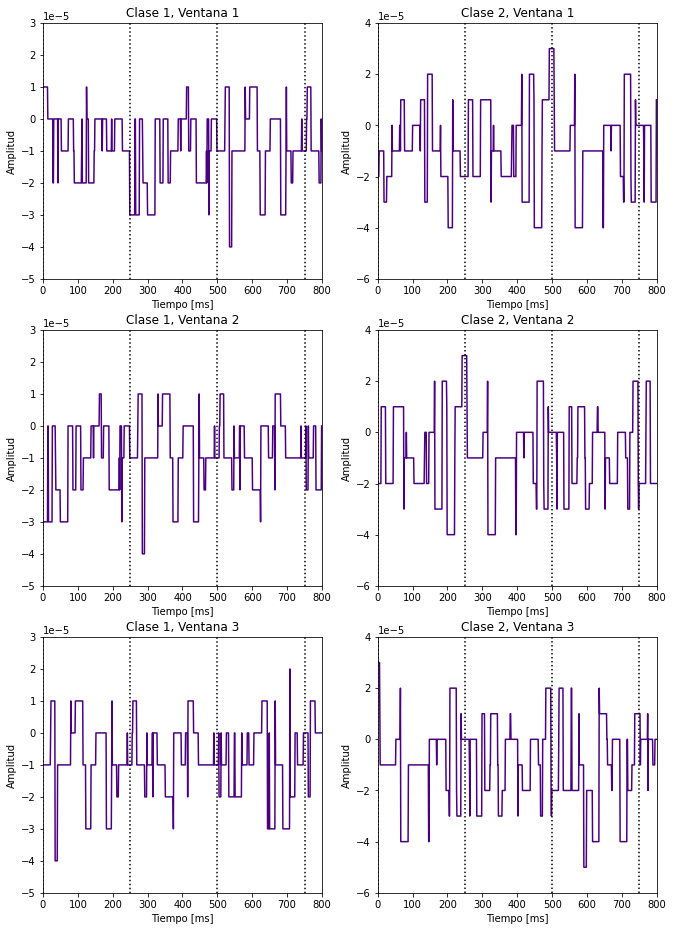

In [18]:
plots = {'Serie': [0,0,0,2,2,2],'Clase': [1,1,1,2,2,2], 'Win' : [1,2,3,1,2,3],
         'Limites': [[-5*1e-5, 3*1e-5],[-5*1e-5, 3*1e-5],[-5*1e-5, 3*1e-5],
                     [-6*1e-5, 4*1e-5],[-6*1e-5, 4*1e-5],[-6*1e-5, 4*1e-5]]}
fig, ax = plt.subplots(3, 2,figsize=(11, 16))

ypoints = np.array([-6*1e-5,4*1e-5])

i = 1
for n in range(2):
  for m in range(3):
    ax[m,n].plot(range(800),df_train[i][0], color = 'indigo')
    for j in range(0,4):
      ax[m,n].plot([j*250]*2, ypoints, linestyle = 'dotted', color = 'k')
    ax[m,n].set_ylim(plots['Limites'][i-1])
    ax[m,n].set_xlim(0,800)
    ax[m,n].set_xlabel('Tiempo [ms]')
    ax[m,n].set_ylabel('Amplitud')
    title_plt = 'Clase ' + str(plots['Clase'][i-1]) + ', Ventana ' + str(
        plots['Win'][i-1])
    i += 1
    ax[m,n].set_title(title_plt)
    #ax[m,n].show()

## Gráficos de ventanas de test

Se observa que siguen una organización aleatoria, ya que no hay superposición de señales.

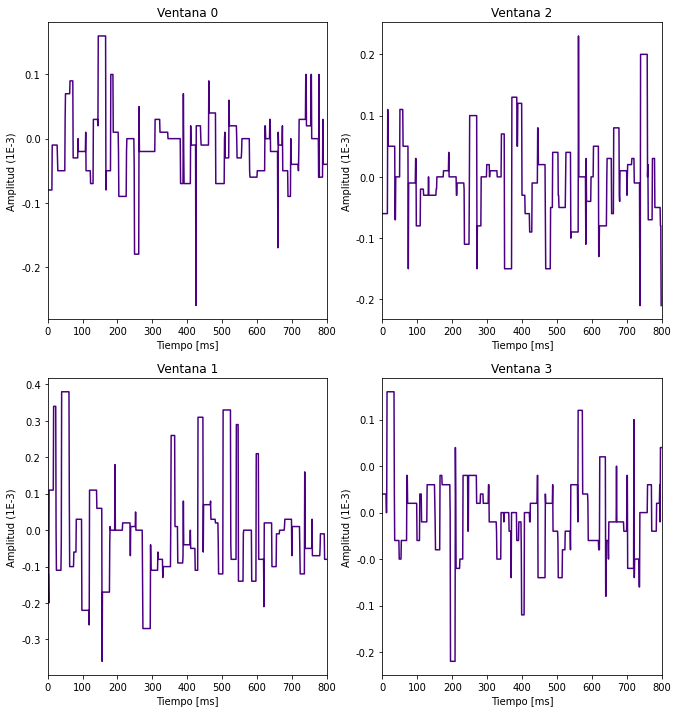

In [19]:
fig, ax = plt.subplots(2, 2,figsize=(11, 12))
i = 0
for n in range(2):
  for m in range(2):
    ax[m,n].plot(range(800),windows_test[i][0], color = 'indigo')
    ax[m,n].set_xlim(0,800)
    ax[m,n].set_xlabel('Tiempo [ms]')
    title_plt = 'Ventana ' + str(i)
    ax[m,n].yaxis.set_major_formatter(FuncFormatter(lambda x,
                                                    pos: ('%.1f')%(x*1e3)))
    ax[m,n].set_ylabel('Amplitud (1E-3)')
    i += 1
    ax[m,n].set_title(title_plt)

# 4. Imágenes 

In [20]:
df_test = windows_test

### Ejemplos de imágenes de ventanas de entrenamiento

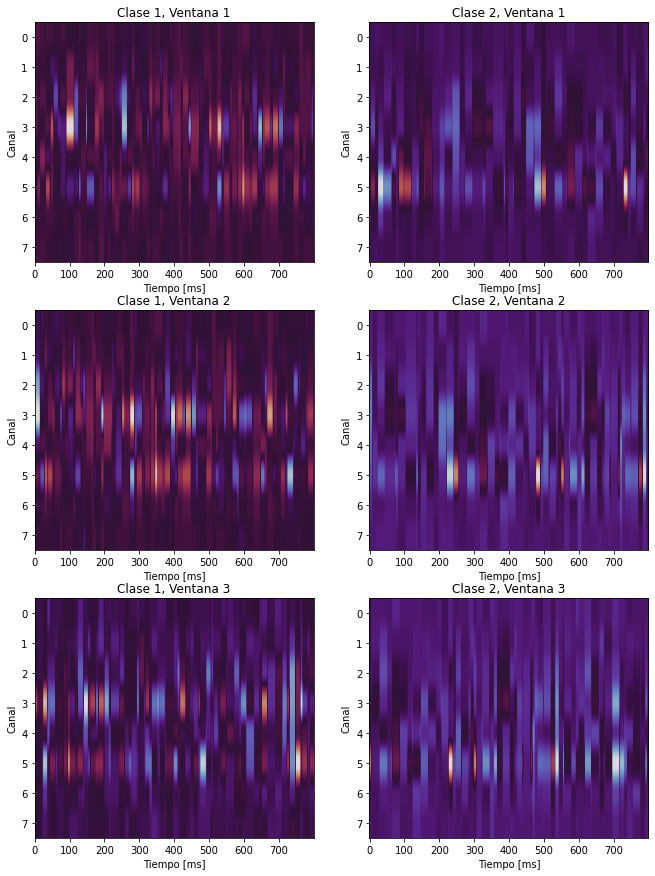

In [21]:
plots = {'Serie': [0,0,0,2,2,2],'Clase': [1,1,1,2,2,2], 'Win' : [1,2,3,1,2,3],
         'Limites': [[-5*1e-5, 3*1e-5],[-5*1e-5, 3*1e-5],[-5*1e-5, 3*1e-5],
                     [-6*1e-5, 4*1e-5],[-6*1e-5, 4*1e-5],[-6*1e-5, 4*1e-5]]}
fig, ax = plt.subplots(3, 2,figsize=(11, 15))

ypoints = np.array([-6*1e-5,4*1e-5])
i = 1
for n in range(2):
  for m in range(3):
    ax[m,n].imshow(df_train[i], cmap='twilight', aspect='auto')
    ax[m,n].set_xlabel('Tiempo [ms]')
    ax[m,n].set_ylabel('Canal')
    title_plt = 'Clase ' + str(plots['Clase'][i-1]) + ', Ventana ' + str(
        plots['Win'][i-1])
    i += 1
    j += 1
    ax[m,n].set_title(title_plt)
    #ax[m,n].show()

### Ejemplos de imágenes de ventanas de test

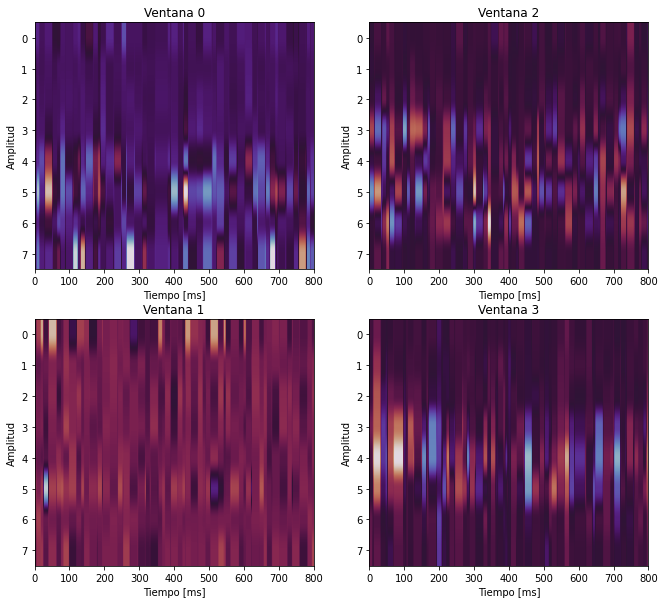

In [22]:
fig, ax = plt.subplots(2, 2,figsize=(11, 10))
i = 0
for n in range(2):
  for m in range(2):
    ax[m,n].imshow(df_test[i], cmap='twilight', aspect='auto')
    ax[m,n].set_xlim(0,800)
    ax[m,n].set_xlabel('Tiempo [ms]')
    ax[m,n].set_ylabel('Amplitud')
    title_plt = 'Ventana ' + str(i)
    i += 1
    ax[m,n].set_title(title_plt)

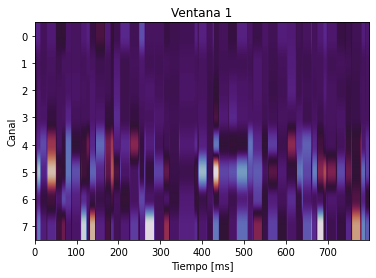

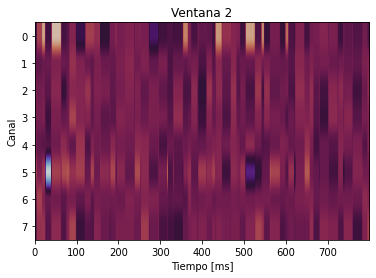

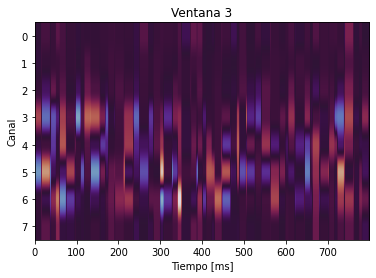

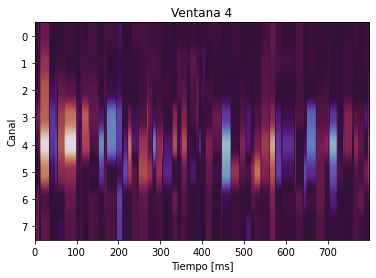

In [23]:
plots = {'Win' : [1,2,3,4]}
for i in range(4): 
  plt.imshow(df_test[i], cmap='twilight', aspect='auto')
  plt.xlabel('Tiempo [ms]')
  plt.ylabel('Canal')
  title_plt = 'Ventana ' + str(plots['Win'][i])
  plt.title(title_plt)
  plt.show()

Se reforman las matrices para obtener imágenes de 80x80, que sean más simples de manejar con conv2d.

In [24]:
df_train_t = []
for i in range(len(df_train)):
  df_train_t.append(np.reshape(np.array(df_train[i]), (80,80)))
df_train_T0 = np.array(df_train_t)
df_train_T = np.expand_dims(df_train_T0, axis=1)

df_val_t = []
for i in range(len(df_val)):
  df_val_t.append(np.reshape(np.array(df_val[i]), (80,80)))
df_val_T0 = np.array(df_val_t)
df_val_T = np.expand_dims(df_val_T0, axis=1)

df_prueba_t = []
for i in range(len(df_prueba)):
  df_prueba_t.append(np.reshape(np.array(df_prueba[i]), (80,80)))
df_prueba_T0 = np.array(df_prueba_t)
df_prueba_T = np.expand_dims(df_prueba_T0, axis=1)

df_test_t = []
for i in range(len(df_test)):
  df_test_t.append(np.reshape(np.array(df_test[i]), (80,80)))
df_test_T0 = np.array(df_test_t)
df_test_T = np.expand_dims(df_test_T0, axis=1)

### Conjunto de entrenamiento

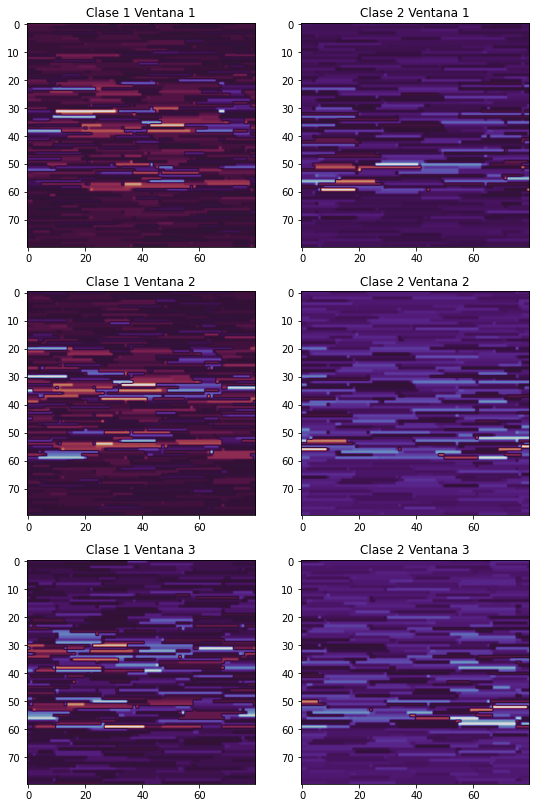

In [25]:
plots = {'Serie': [0,0,0,2,2,2],'Clase': [1,1,1,2,2,2], 'Win' : [1,2,3,1,2,3],
         'Limites': [[-5*1e-5, 3*1e-5],[-5*1e-5, 3*1e-5],[-5*1e-5, 3*1e-5],
                     [-6*1e-5, 4*1e-5],[-6*1e-5, 4*1e-5],[-6*1e-5, 4*1e-5]]}
fig, ax = plt.subplots(3, 2,figsize=(9, 14))

ypoints = np.array([-6*1e-5,4*1e-5])
i = 1
for n in range(2):
  for m in range(3):
    ax[m,n].imshow(df_train_T[i][0], cmap='twilight', aspect='auto')
    title_plt = 'Clase ' + str(plots['Clase'][i-1]) + ' Ventana ' + str(
        plots['Win'][i-1])
    i += 1
    j += 1
    ax[m,n].set_title(title_plt)
    #ax[m,n].show()

### Conjunto de test

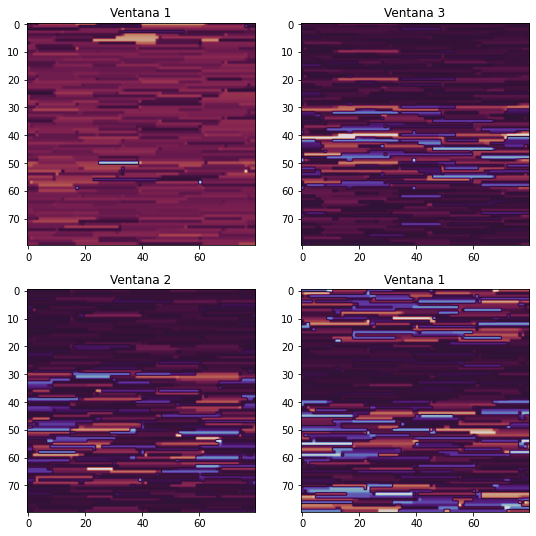

In [26]:
fig, ax = plt.subplots(2, 2,figsize=(9, 9))
i = 1
for n in range(2):
  for m in range(2):
    ax[m,n].imshow(df_test_T[i][0], cmap='twilight', aspect='auto')
    title_plt = 'Ventana ' + str(plots['Win'][i-1])
    i += 1
    ax[m,n].set_title(title_plt)

# 5. Estructura de red

Se implementa el dispositivo GPU a utilizar(cuda).

In [27]:
torch.cuda.is_available()

True

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Se define el número de épocas, el tamaño de los *batches* y la tasa de aprendizaje.

In [29]:
# Epochs
#n_epochs = 100
# Batch size
batch_size = 32
# Learning rate
lr = 1e-3
classes = list(range(6))

Se crean los datasets y dataloaders a partir de los conjuntos.

In [30]:
# Datasets
feats_train = df_train_T
labels_train = df_train_labels
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val_T
labels_val = df_val_labels
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_prueba = df_prueba_T
labels_prueba = df_prueba_labels
dataset_prueba = [ {"features":feats_prueba[i,:], "labels":labels_prueba[i]} for i in range(feats_prueba.shape[0]) ]

feats_test = df_test_T
dataset_test = [ {"features":feats_test[i,:]} for i in range(feats_test.shape[0]) ]

# Dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

dataloader_prueba = torch.utils.data.DataLoader(dataset_prueba, batch_size=303, shuffle=True, num_workers=0)

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=672, shuffle=True, num_workers=0)

Para verificar que estén bien implementados, se generan muestras de los conjuntos:

### Muestra Test

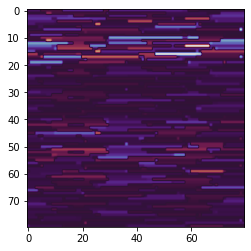

In [31]:
for i, data in enumerate(dataloader_test, 0):
  # Process the current batch
  inputs = data["features"]
plt.imshow(inputs[1][0], cmap='twilight')   

### Muestra Train

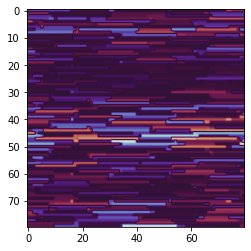

In [32]:
for i, data in enumerate(dataloader_train, 0):
  # Process the current batch
  inputs = data["features"]
plt.imshow(inputs[1][0], cmap='twilight')   

### Muestra Validation

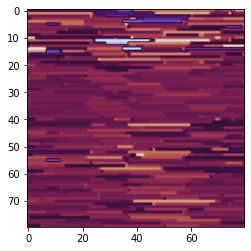

In [33]:
for i, data in enumerate(dataloader_val, 0):
  # Process the current batch
  inputs = data["features"]
plt.imshow(inputs[1][0], cmap='twilight')   

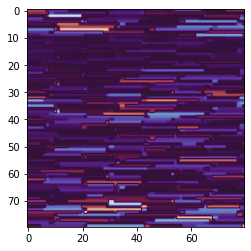

In [34]:
for i, data in enumerate(dataloader_prueba, 0):
  # Process the current batch
  inputs = data["features"]
plt.imshow(inputs[1][0], cmap='twilight')   

In [35]:
inputs.shape

torch.Size([255, 1, 80, 80])

# Model

In [36]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    self.bn0 = torch.nn.BatchNorm2d(1)
    self.conv1 = nn.Conv2d(1, 3, 3, padding = 'same')
    self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.bn1 = torch.nn.BatchNorm2d(3)
    self.drop1 = nn.Dropout2d(p=0.001)
    self.conv2 = nn.Conv2d(3, 6, 5, padding = 'same')
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.bn2 = torch.nn.BatchNorm2d(6)
    self.drop2 = nn.Dropout2d(p=0.001)
    self.conv3 = nn.Conv2d(4, 4, 3, padding = 'same')
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.bn3 = torch.nn.BatchNorm2d(4)
    self.drop3 = nn.Dropout2d(p=0.001)

    self.fc1 = nn.Linear(2166, 6)

  def forward(self,x):

    x = self.bn0(x)
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = self.bn1(x)
    x = self.drop1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    # Flattening:
    x = torch.flatten(x, 1)
    x = self.fc1(x)

    return x

# Correr el modelo m veces y obtener él con el mejor resultado y sus predicciones:

In [38]:
def run(n_epochs):
  loss_per_epoch_train = 0
  loss_per_epoch_val = 0

  loss_train = []
  loss_val = []

  y_pred = []
  y_true = []

  model = ConvNet().to(device=device)#, dtype=torch.float)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  start = time.time()

  n_total_steps = len(dataloader_train)
  # Se itera sobre los datos n_epochs veces:
  for epoch in range(n_epochs):
    model.train()
    # Se entrena en la época actual:
    for i, data in enumerate(dataloader_train, 0):
      # Se procesa cada batch:
      inputs = data["features"].to(device)
      inputs = inputs.cuda()
      inputs = inputs.float()

      labels = data["labels"]
      labels = labels.type(torch.LongTensor)
      labels = labels.to(device)
      labels = labels.cuda()
    
      # Forward pass:
      outputs = model(inputs)
      loss = criterion(outputs, labels)
    
      # Parameter gradients to zero
      optimizer.zero_grad()

      # Backward pass and optimize:
      loss.backward()
      optimizer.step()

      loss_per_epoch_train += loss.cpu().item()

    #print('End of training')
    # Pérdida de entrenamiento:
    loss_per_epoch_train = loss_per_epoch_train/(i+1)
    loss_train.append(loss_per_epoch_train)
    loss_per_epoch_train = 0


    with torch.no_grad():
      # Se prueba el modelo sobre validación:
      n_correct = 0
      n_samples = 0
      n_correct_class = [0 for i in range(6)]
      n_samples_class = [0 for i in range(6)]
  
      for j, data in enumerate(dataloader_val, 0):
        inputs = data["features"].to(device)
        inputs = inputs.cuda()
        inputs = inputs.float()
    
        labels = data["labels"]
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        labels = labels.cuda()

        outputs = model(inputs)
        # torch.max returns (data, index)
        (q, predicted) = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()
        n_samples += labels.size(0)
        #print(n_samples)

        for k in range(len(labels)):
          label = int(labels[k].item())
          pred = predicted[k]
          if label == pred:
            n_correct_class[label] += 1
          n_samples_class[label] += 1

        for a in labels.tolist():
          y_true.append(a)

        for b in predicted.tolist():
          y_pred.append(b)

        loss = criterion(outputs, labels)

        loss_per_epoch_val += loss.item()


        accuracy = 100 * n_correct/n_samples
        # Train/validation loss and accuracy for the current epoch
        #print(f'Epoch: {epoch} - Accuracy score: {accuracy} - Loss obtained: {loss} %')
        for m in range(6):
          accuracy = 100 * n_correct_class[m]/n_samples_class[m]
          #print(f'Accuracy of {classes[m]}: {accuracy} %')


    # VALIDATION LOSS 
    loss_per_epoch_val = loss_per_epoch_val/(j+1)
    loss_val.append(loss_per_epoch_val)
    loss_per_epoch_val = 0


  end = time.time()
  #print('Finished Training, total time %f seconds' % (end - start))

  for i, data in enumerate(dataloader_prueba, 0):
    inputs = data["features"].to(device)
    inputs = inputs.cuda()
    inputs = inputs.float()

  y_true = data["labels"]
  y_true = y_true.type(torch.LongTensor)
  y_true = y_true + 1

  outputs = model(inputs)
  (q, predicted) = torch.max(outputs, 1)
  y_pred01 = pd.DataFrame(predicted.cpu(),columns=['Category'])
  y_pred01 = y_pred01 + 1

  x = accuracy_score(y_true, y_pred01)

  for i, data in enumerate(dataloader_test, 0):
    inputs = data["features"].to(device)
    inputs = inputs.cuda()
    inputs = inputs.float()

  outputs = model(inputs)

  (q, predicted) = torch.max(outputs, 1)
  y_pred0 = pd.DataFrame(predicted.cpu(),columns=['Category'])
  y_pred0 = y_pred0 + 1

  return x, y_pred0, y_pred01, y_true, loss_train, loss_val

In [96]:
th = 0.7
# Número de épocas
n=5
# Número de iteraciones
m = 10
scores = []
i = 0
while i < th:
  for k in range(m):
    x = run(n)
    scores.append(x)
  z = max(scores)
  i = z[0]

Accuracy conjunto prueba(10% de los datos):

In [97]:
z[0]

0.8705882352941177

Exportar predicciones a drive:

In [56]:
#z[1].to_excel(excel_writer=r'/content/drive/MyDrive/Pred0.xlsx')

Loss function:

Text(0, 0.5, 'Loss')

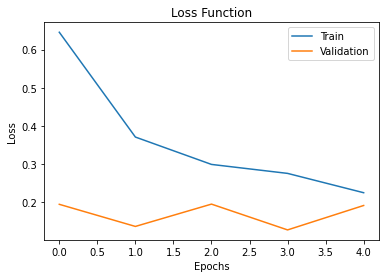

In [98]:
# z[4] es el loss de entrenamineto y z[5] el de validación
plt.plot(range(n),z[4])
plt.plot(range(n),z[5])
plt.legend(['Train', 'Validation'])
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Matriz de confusión:

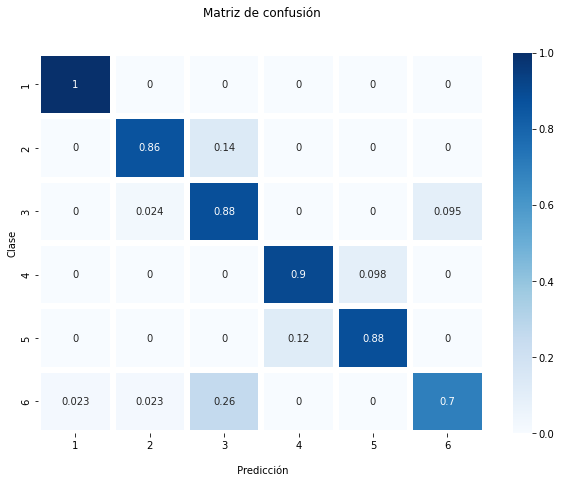

In [100]:
cf_matrix = confusion_matrix(z[3], z[2], normalize='true')
fig, ax_sca = plt.subplots(figsize=(10,7))   
ax_sca = sns.heatmap(cf_matrix, annot=True, cmap='Blues', linewidths=5)
ax_sca.set_title('Matriz de confusión\n\n');
ax_sca.set_xlabel('\n Predicción')
ax_sca.set_ylabel('Clase');
ax_sca.xaxis.set_ticklabels(['1','2','3','4','5','6'])
ax_sca.yaxis.set_ticklabels(['1','2','3','4','5','6'])
plt.show()

Predicciones de Ventanas Test(672)

In [101]:
z[1]

,Category
0,3
1,6
2,2
3,3
4,2
...,...
667,6
668,1
669,2
670,3


## Función run:

correr(num_epochs) = accuracy, predictions_test, predictions_prueba, predictions_true, loss_train, loss_val

# Extra

In [102]:
y_pred0 = z[1]

In [103]:
a=0
b=0
c=0
d=0
e=0
f=0
for i in y_pred0.index:
  if y_pred0['Category'][i] == 1:
    a += 1
  elif y_pred0['Category'][i] == 2:
    b += 1
  elif y_pred0['Category'][i] == 3:
    c += 1
  elif y_pred0['Category'][i] == 4:
    d += 1
  elif y_pred0['Category'][i] == 5:
    e += 1
  elif y_pred0['Category'][i] == 6:
    f += 1

In [104]:
a,b,c,d,e,f

(117, 156, 125, 134, 49, 91)